In [1]:
import numpy as np
import netCDF4 as nc
import pandas as pd
from scipy.interpolate import PchipInterpolator



import matplotlib as mpl
font = {'family' : 'sans',
        'size'   : 12}

mpl.rc('font', **font)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, LogLocator, MaxNLocator
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from cmcrameri import cm

from proteus.utils.plot import _preset_colours, get_colour, latexify

In [2]:
import utils.load_grid as lg

In [3]:
from proteus.config import read_config
from proteus.atmos_clim.common import read_atmosphere_data
from proteus.utils.constants import vol_list


In [4]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'

# %matplotlib widget

In [7]:
outdir = "data/shared/l98d_chemstudy/"

In [8]:
help = pd.read_csv(outdir+"runtime_helpfile.csv", sep=r"\s+")

In [9]:
data_photo = pd.read_csv(outdir + 'offchem_photo/vulcan.csv', sep=r'\s+')
data_photo.keys()

Index(['tmp', 'p', 'z', 'Kzz', 'OH', 'H2', 'H2O', 'H', 'O', 'CH', 'C', 'CH2',
       'CH3', 'CH4', 'C2', 'C2H2', 'C2H', 'C2H3', 'C2H4', 'C2H5', 'C2H6', 'CO',
       'CO2', 'CH2OH', 'H2CO', 'HCO', 'CH3O', 'CH3OH', 'CH3CO', 'O2', 'H2CCO',
       'HCCO', 'N', 'NH', 'CN', 'HCN', 'NO', 'NH2', 'N2', 'NH3', 'N2H2', 'N2H',
       'N2H3', 'N2H4', 'HNO', 'H2CN', 'HNCO', 'NO2', 'N2O', 'C4H2', 'CH2NH2',
       'CH2NH', 'CH3NH2', 'CH3CHO', 'HNO2', 'NCO', 'HO2', 'H2O2', 'HC3N',
       'CH3CN', 'CH2CN', 'C2H3CN', 'SH', 'HSO', 'H2S', 'C3H3', 'C3H2', 'C3H4',
       'C6H5', 'C6H6', 'S', 'S2', 'SO', 'CS', 'COS', 'CS2', 'NS', 'HS2', 'SO2',
       'S4', 'S8', 'HCS', 'S3', 'C4H3', 'C4H5', 'S2O', 'CH3SH', 'CH3S', 'He'],
      dtype='object')

In [10]:
data_nophoto = pd.read_csv(outdir + 'offchem_nophoto/vulcan.csv', sep=r'\s+')
data_nophoto.keys()

Index(['tmp', 'p', 'z', 'Kzz', 'OH', 'H2', 'H2O', 'H', 'O', 'CH', 'C', 'CH2',
       'CH3', 'CH4', 'C2', 'C2H2', 'C2H', 'C2H3', 'C2H4', 'C2H5', 'C2H6', 'CO',
       'CO2', 'CH2OH', 'H2CO', 'HCO', 'CH3O', 'CH3OH', 'CH3CO', 'O2', 'H2CCO',
       'HCCO', 'N', 'NH', 'CN', 'HCN', 'NO', 'NH2', 'N2', 'NH3', 'N2H2', 'N2H',
       'N2H3', 'N2H4', 'HNO', 'H2CN', 'HNCO', 'NO2', 'N2O', 'C4H2', 'CH2NH2',
       'CH2NH', 'CH3NH2', 'CH3CHO', 'HNO2', 'NCO', 'HO2', 'H2O2', 'HC3N',
       'CH3CN', 'CH2CN', 'C2H3CN', 'SH', 'HSO', 'H2S', 'C3H3', 'C3H2', 'C3H4',
       'C6H5', 'C6H6', 'S', 'S2', 'SO', 'CS', 'COS', 'CS2', 'NS', 'HS2', 'SO2',
       'S4', 'S8', 'HCS', 'S3', 'C4H3', 'C4H5', 'S2O', 'CH3SH', 'CH3S', 'He'],
      dtype='object')

In [11]:
time = lg.get_nc_years(outdir)[-1]
data_outgas = read_atmosphere_data(outdir, [time], extra_keys=["x_gas","pl"])[0]

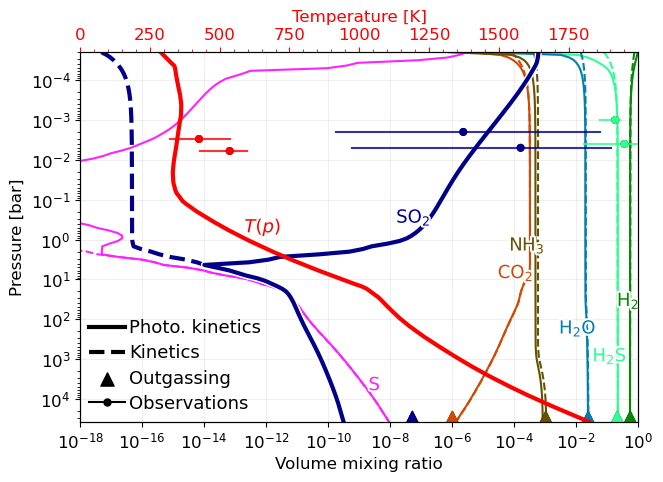

In [12]:
figscale = 1.2
fig, ax = plt.subplots(1,1, figsize=(6*figscale, 4*figscale))
axr = ax.twiny()

lw = 1.5
x_min = 1e-18
x_max = 1
fs = 13

# highlight change in chosen gas
p_obs = [1e-4, 1e-2]
g_obs = "SO2"

# gases to plot
gases = ["S","H2S","H2O","H2","CO2","NH3","SO2"]

surf_vmr = []
x_obs = [0.0,0.0]
for j,g in enumerate(gases):

    c = get_colour(g)
    v = 0.0

    # plot from profile
    k = f"{g}_vmr"
    if k in data_outgas.keys():
        po = data_outgas["pl"][:] / 1e5
        x = data_outgas[k][:]
        x = np.append(x, x[-1])
        ax.scatter(x[-1], po[-3], s=90, color=c, marker='^', zorder=10, path_effects=[pe.withStroke(linewidth=1, foreground='k')])

    _lw = lw
    _pe = None
    if g == g_obs:
        _lw = lw * 2
        _pe = [pe.withStroke(linewidth=_lw+2, foreground='w')]

    # plot from offchem, no photochemistry
    pn = data_nophoto["p"].values / 1e5
    x = data_nophoto[g].values
    yy = np.linspace(np.log10(pn[0]),np.log10(pn[-1]), 140)
    xx = PchipInterpolator(np.log10(pn), x)(yy)
    ax.plot(xx,10**yy , lw=_lw, color=c, ls='dashed', path_effects=_pe)

    # plot from offchem, photochemistry
    pp = data_photo["p"].values / 1e5
    x = data_photo[g].values
    xx = PchipInterpolator(np.log10(pn), x)(yy)
    ax.plot(xx,10**yy, lw=_lw, color=c, ls='solid', path_effects=_pe)
    surf_vmr.append(x[-1])

    # add legend
    idx = -4 - 3*j
    x_txt = max(x[idx]*2, x_min*10)
    p_txt = pp[idx]
    ax.text(x_txt,p_txt, latexify(g), ha='right', va='bottom',
                fontsize=fs, color=c, path_effects=[pe.withStroke(linewidth=3, foreground='w')])

# add observations
for j,d in enumerate([ ("H2S", -0.74, +0.14, -0.49), # gressier
                       ("SO2", -5.64, +4.41, -4.12), # gressier
                       ("tmp", 426.0, +111,  -105),  # gressier
                       ("H2S", -0.44, +0.42, -1.30), # banerjee
                       ("SO2", -3.79, +2.90, -5.45), # banerjee
                       ("tmp", 536.0, +62,   -106),  # banerjee
                     ]):

    g  = d[0]
    x  = d[1]
    xp = d[1]+d[2]
    xm = d[1]+d[3]

    p = 1e-3 * (j+1)

    if g == "tmp":
        c = "red"
        axx = axr
    else:
        c = get_colour(g)
        axx = ax
        x = 10**x
        xp = 10**xp
        xm = 10**xm

    axx.plot([xm,xp], [p,p], lw=lw, color=c, ls='solid', alpha=0.8)
    # axx.plot([x,x], [p/5,p*5], lw=lw, color=c, ls='solid', alpha=0.8)
    axx.scatter(x,p, s=90, color=c, marker='.', zorder=10, path_effects=[pe.withStroke(linewidth=1, foreground='k')])


# highlight differences
# for p in p_obs:
#     i = np.argmin(np.abs(pn - p))
#     x0 = data_nophoto[g_obs][i]
#     i = np.argmin(np.abs(pp - p))
#     x1 = data_photo[g_obs][i]
#     dx = np.log10(x1/x0)

#     ax.annotate("", xy=(x1, p), xytext=(x0, p), arrowprops=dict(arrowstyle="->", lw=1, color='black'))
#     ax.text(1e-9, p, r"$\times 10^{%.1f}$"%dx, ha='center', va='bottom', fontsize=10, color='black')


# temperature profile
col = 'red'
tmp = data_outgas["t"]
prs = data_outgas["p"]/1e5
tmp = PchipInterpolator(np.log10(prs),tmp)(yy)
prs = 10**yy
idx = int(len(prs)/2)
axr.plot(tmp, prs, lw=lw*2, color=col, ls='solid', zorder=0)
axr.text(tmp[idx],prs[idx], r"$T(p)$", ha='left', va='bottom', fontsize=fs, color=col, path_effects=[pe.withStroke(linewidth=3, foreground='w')])
axr.set_xlabel("Temperature [K]", color=col)
axr.xaxis.set_major_locator(MultipleLocator(250))
axr.xaxis.set_minor_locator(MultipleLocator(50))
axr.set_xlim(left=0, right=1999)
axr.tick_params(axis='x', colors=col, which='both')
axr.set_zorder(0)


# legend
ax.plot([],[], label="Photo. kinetics",  color='black', lw=lw*2, ls='solid')
ax.plot([],[], label="Kinetics",         color='black', lw=lw*2, ls='dashed')
ax.scatter([],[], label="Outgassing",         color='black', s=90,  marker='^')
ax.errorbar([],[], label="Observations",        color='black', markersize=10, marker='.')
ax.legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize=fs,
          frameon=False, handlelength=2, handletextpad=0.2,
          borderpad=0, labelspacing=0.4)

# decorate
for axx in (ax,axr):
    axx.set_yscale("log")
    axx.set_ylim(top=np.amin(pp), bottom=np.amax(pp))
ax.set_ylabel("Pressure [bar]")
ax.grid(zorder=-2, alpha=0.2)
ax.set_xlim(left=x_min, right=x_max)
ax.set_xscale("log")
ax.set_xlabel("Volume mixing ratio")
ax.xaxis.set_major_locator(LogLocator(base=10.0))

plt.show()
fig.savefig("output/fig_chem.pdf", bbox_inches='tight', dpi=300)